In [1]:
from dataclasses import dataclass, asdict
from functools import partial
from datetime import datetime

In [2]:
from ipynb.fs.full.quantumsystem import *

In [3]:
from ipynb.fs.full.MovementSystem import *

In [4]:
from ipynb.fs.full.DamageSystem import *

In [5]:
from ipynb.fs.full.WeaponsSystem import *

In [6]:
qs.quantum_system_name = "MechaCombatSystem"

In [7]:
class Size(QuantumSystem.System):
    pass

class TMM(QuantumSystem.System):
    pass

In [8]:
class Special(QuantumSystem.System):
    edge_name = "special"

In [9]:
class Faction(QuantumSystem.System):
    """ A unified group in the game """

In [10]:
class Structure(QuantumSystem.HyperSystem):
    systems = [XYLocation, Elevation, Armor, Faction]
    
    @classmethod
    def buildStructureFactory(cls, systemDefaults):
        return partial(
            cls.build_system,
            terminants=systemDefaults)

In [11]:
StructureFactories = {
    "Landscape": Structure.buildStructureFactory([
        json.dumps([0, 0]),  # XYLocation System
        "5",  # Elevation System
        ["100", "100"],  # Armor System
        "Unaligned"  # Faction System
    ]),
    "Apartment Tower": Structure.buildStructureFactory([
        json.dumps([0, 0]),  # XYLocation System
        "5",  # Elevation System
        ["4", "2"],  # Armor System
        "Unaligned"  # Faction System
    ]),
    "Foundry": Structure.buildStructureFactory([
        json.dumps([0, 0]),  # XYLocation System
        "5",  # Elevation System
        ["8", "6"],  # Armor System
        "Unaligned"  # Faction System
    ]),
    "Factory": Structure.buildStructureFactory([
        json.dumps([0, 0]),  # XYLocation System
        "5",  # Elevation System
        ["7", "5"],  # Armor System
        "Unaligned"  # Faction System
    ]),
    "Office Tower": Structure.buildStructureFactory([
        json.dumps([0, 0]),  # XYLocation System
        "5",  # Elevation System
        ["5", "4"],  # Armor System
        "Unaligned"  # Faction System
    ]),
    "Warehouse": Structure.buildStructureFactory([
        json.dumps([0, 0]),  # XYLocation System
        "5",  # Elevation System
        ["7", "4"],  # Armor System
        "Unaligned"  # Faction System
    ]),
    "Road": Structure.buildStructureFactory([
        json.dumps([0, 0]),  # XYLocation System
        "5",  # Elevation System
        ["1", "0"],  # Armor System
        "Unaligned"  # Faction System
    ])
}

Received: Movement relationship not found on ApartmentB


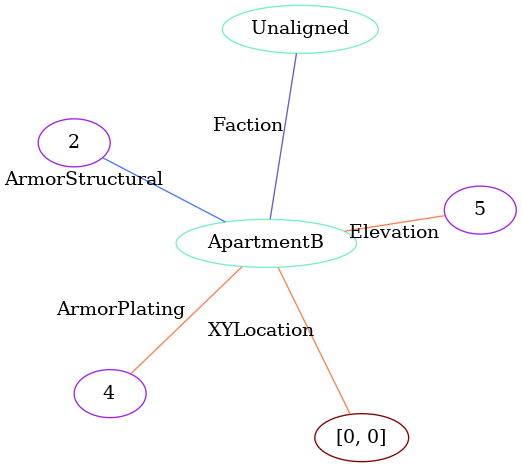

In [12]:
if __name__ == "__main__":
    from IPython.display import display
    qs.reset()

    StructureFactories['Apartment Tower']('ApartmentB') 
    try:
        Move.move("ApartmentB", [1, 0, 0])
    except Exception as e:
        print(f"Received: {e}")
    display(qs.render())

In [13]:
class MechType(QuantumSystem.System):
    edge_name = "mech_type"

class MechModel(QuantumSystem.System):
    edge_name = "mech_model"

class MechRole(QuantumSystem.System):
    edge_name = "mech_role"
    
class PointValue(QuantumSystem.System):
    edge_name = "point_value"
    
class MechDefinition(QuantumSystem.HyperSystem):
    systems = [MechType, MechModel, MechRole, Size, TMM, Special, PointValue]

In [14]:
class Unit(QuantumSystem.HyperSystem):
    systems = [Move, Weapons, UnitDamage, Faction]

class Mech(QuantumSystem.HyperSystem):
    systems = [Unit, MechDefinition]
    
    @classmethod
    def buildMechFactory(cls, systemDefaults):
        def newMechFactory(mechName, faction):
            systemDefaults[0][3] = faction
            return cls.build_system(mechName, terminants=systemDefaults)
        return newMechFactory

In [15]:
MechFactories = {
    "Kingfisher Prime": Mech.buildMechFactory([
        [   # Unit System
            [  # Move System
                json.dumps([0, 0]), "0", "8j"
            ],
            [  # Weapons System
                [["0", "6"]], [["2", "6"]], [["4", "3"]], ["1", "3"]
            ],
            [  # Unit Damage System
                ["9", "7"], ["1", "4", "4", "4"]
            ],
            "Unaligned"
        ],
        [  # Mech Definition System
            "BM", "Kingfisher Prime", "Brawler", "4", "1", json.dumps(["OMNI", "CASE", "IF01"]), "54"
        ]
    ]),
    "Atlas": Mech.buildMechFactory([
        [   # Unit System
            [  # Move System
                json.dumps([0, 0]), "0", "6"
            ],
            [  # Weapons System
                [["0", "4"]], [["2", "4"]], [["4", "4"]], ["1", "3"]
            ],
            [  # Unit Damage System
                ["10", "8"], ["1", "4", "4", "4"]
            ],
            "Unaligned"
        ],
        [  # Mech Definition System
            "BM", "Atlas", "Juggernaut", "4", "1", json.dumps(["AC2", "IF1", "LRM1", "REAR2"]), "52"
        ]
    ]),
    "Huntsman": Mech.buildMechFactory([
        [   # Unit System
            [  # Move System
                json.dumps([0, 0]), "0", "10j"
            ],
            [  # Weapons System
                [["0", "3"]], [["2", "3"]], [["4", "2"]], ["3", "3"]
            ],
            [  # Unit Damage System
                ["6", "3"], ["1", "4", "4", "4"]
            ],
            "Unaligned"
        ],
        [  # Mech Definition System
            "BM", "Huntsman", "Sniper", "2", "2", json.dumps(["OMNI", "CASE", "IF1", "FLK0"]), "37"
        ]
    ])
}

In [16]:
ObjectFactories = {**MechFactories, **StructureFactories}

Received: Cannot move unit further (15.066519173319364) than its movement speed (8)


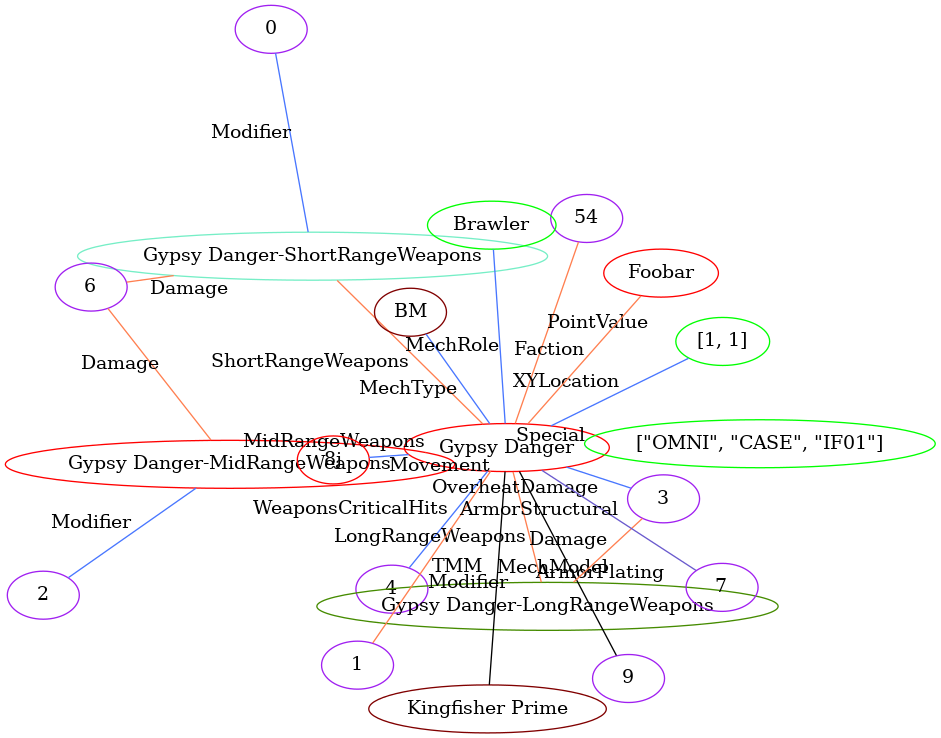

In [17]:
if __name__ == "__main__":
    from IPython.display import display

    qs.reset()
    MechFactories['Kingfisher Prime']("Gypsy Danger", "Foobar")
    Move.move("Gypsy Danger", [1, 1, 1])
    try:
        Move.move("Gypsy Danger", [15, 1, 1])
    except AssertionError as ae:
        print(f"Received: {ae}")
    display(qs.render())

In [18]:
class GameObject(QuantumSystem.System):
    """ Connects a game object to the gamestate """

class RoundCount(QuantumSystem.System):
    """ Records the number of rounds since the game began """

In [19]:
class GameEventTime(QuantumSystem.System):
    """ Which Team Is Active"""

class GameEventType(QuantumSystem.System):
    """ Which Team Is Active"""
    
class GameEventTeam(QuantumSystem.System):
    """ Which Team Is Active"""
    
class GameEventValue(QuantumSystem.System):
    """ Which Team Is Active"""
    
class GameEventResult(QuantumSystem.System):
    """ Which Team Is Active"""

class GameEvent(QuantumSystem.MetaSystem):
    """ Game Event Record """

    @classmethod
    def meta_anchor(cls, anchor):
        return f"{anchor}-{cls.__name__}--{datetime.utcnow().isoformat()}"
    
    systems = [RoundCount, GameEventType, GameEventTeam, GameObject, GameEventValue, GameEventResult]

In [20]:
if __name__ == "__main__":
    qs.reset()
    de = GameEvent.build_system("all_events", ("1", "Attack", "Team1", "Knifehead", "Gypsy Danger", "20"))
    qs.render()

In [21]:
class GamePhase(QuantumSystem.System):
    """ The Play Phase is defined as alternated rounds of "Move" and "Action" """
    legalStates = ["Add", "Move", "Action", "Resolution"]

class Faction(QuantumSystem.System):
    """ Faction participating in game """        
    @classmethod
    def build_system(cls, anchor, terminant):
        if not isinstance(terminant, list):
            terminants = [terminant]
        else:
            terminants = terminant
            for terminant in terminants:
                QuantumSystem.add_entity(anchor, **{cls.__name__: terminant})
        return anchor

class FactionPlay(QuantumSystem.System):
    """ Which Faction Is Active"""

In [22]:
class GameState(QuantumSystem.HyperSystem):
    systems = [GamePhase, Faction, FactionPlay, RoundCount]
    memory = []

    @classmethod
    def build_system(cls, terminants=None, ):
        if terminants is None:
            terminants = ["Add", ['Team0', 'Team1'], 'Team0', '0']
        for system, terminant in zip(cls.systems, terminants):
            #TODO: enforce 
            system.build_system(cls.__name__, terminant)
        cls.memory = []
        return cls.__name__

    @classmethod
    def reset(cls):
        qs.reset()
        cls.game_state = GameState.build_system()
        cls.declaredEvents = []

    @classmethod
    def addObject(cls, newGameObject: str):
        GameObject.build_system(cls.__name__, newGameObject)

    @classmethod
    def addFaction(cls, newFaction: str):
        Faction.build_system(cls.__name__, newFaction)

    @classmethod
    def getRoundCount(cls):
        return int(RoundCount.get_relationship(cls.__name__))

    @classmethod
    def resetRoundCount(cls):
        count = cls.getRoundCount()
        QuantumSystem.replace(cls.__name__, RoundCount, str(count), str(0))

    @classmethod
    def incrementRoundCount(cls):
        count = int(RoundCount.get_relationship(cls.__name__))
        QuantumSystem.replace(cls.__name__, RoundCount, str(count), str(count + 1))

    @classmethod
    def getPhase(cls):
        return GamePhase.get_relationship(cls.__name__)
    
    @classmethod
    def setPhase(cls, newPhase):
        assert newPhase in GamePhase.legalStates, f"Unrecognized GamePhase: {newPhase}"
        phase = GamePhase.get_relationship(cls.__name__)
        QuantumSystem.replace(cls.__name__, GamePhase, phase, newPhase)

    @classmethod
    def setFaction(cls, newFaction):
        # TODO: assert newFaction in factions
        faction = FactionPlay.get_relationship(cls.__name__)
        QuantumSystem.replace(cls.__name__, FactionPlay, faction, newFaction)

    @classmethod
    def setPlayPhase(cls, newPhase):
        assert newPhase in PlayPhase.legalStates()
        phase = PlayPhase.get_relationship(cls.__name__)
        QuantumSystem.replace(cls.__name__, PlayPhase, phase, newPhase)

    @classmethod
    def addEvent(cls, newEvent):
        # TODO: Check newEvent legality -- via instantiation?
        #    * instantiation should all create existing graph change set?
        GameEvent.build_system(cls.__name__, newEvent)
        match newEvent[1]:
            case "Move":
                Move.move(newEvent[3], json.loads(newEvent[4]))
            case "Action":
                raise NotImplementedError("Actions aren't implemented")
            case _:
                raise Exception(f"Unrecognized Event Type: {newEvent[1]}")

    @classmethod
    def declareEvent(cls, newEvent):
        # TODO: Check newEvent legality -- via instantiation?
        cls.declaredEvents.append(newEvent)

    @classmethod
    def recantEvent(cls, recantedEvent):
        try:
            cls.declaredEvents.remove(recantedEvent)
        except ValueError:
            pass

    @classmethod
    def resolveEvents(cls):
        for event in cls.declaredEvents:
            cls.addEvent(event)
        cls.declaredEvents = []
        return True
    
    @classmethod
    def nextPhase(cls):
        nextPhase = "Unknown"
        currentPhase = cls.getPhase()
        if currentPhase == "Add":
            nextPhase = "Move"
        elif currentPhase == "Move":
            nextPhase = "Action"
        elif currentPhase == "Action":
            nextPhase = "Move"
        return nextPhase
    
    @classmethod
    def newPhase(cls, currentPhase=None):
        if currentPhase is not None:
            assert currentPhase == cls.getPhase(), f"GameState mismatch. ({currentPhase}!={cls.getPhase()}) Cannot progress in this manner"
        else:
            currentPhase = cls.getPhase()

        all_resolved = cls.resolveEvents()
        if not all_resolved:
            newPhase = currentPhase
        else:
            newPhase = cls.nextPhase()
            if newPhase == "Move":
                cls.incrementRoundCount()
        cls.setPhase(newPhase)

    def cycle(self):
        beforeTransition = self.transitions[-1]
        super().cycle()
        afterTransition = self.transitions[-1]
        if self.getPhase() == "Move" and beforeTransition != afterTransition:
            self.movements.append(afterTransition)

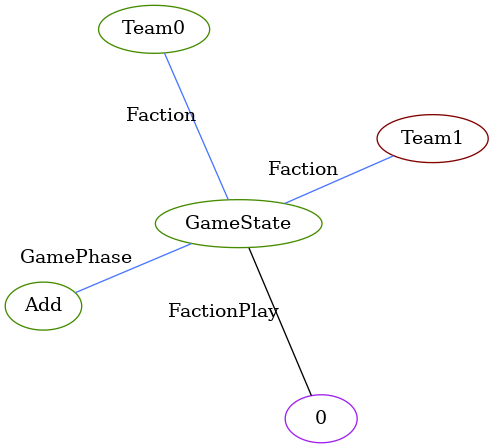

In [23]:
if __name__ == "__main__":
    from IPython.display import display
    GameState.reset()

    # Power up game
    GameState.build_system(["Add", 'foobar', '0'])
    GameState.addFaction("foobar")
    GameState.addFaction("team0")

    # Player presses new game button (Add and annotate)
    display(qs.render())

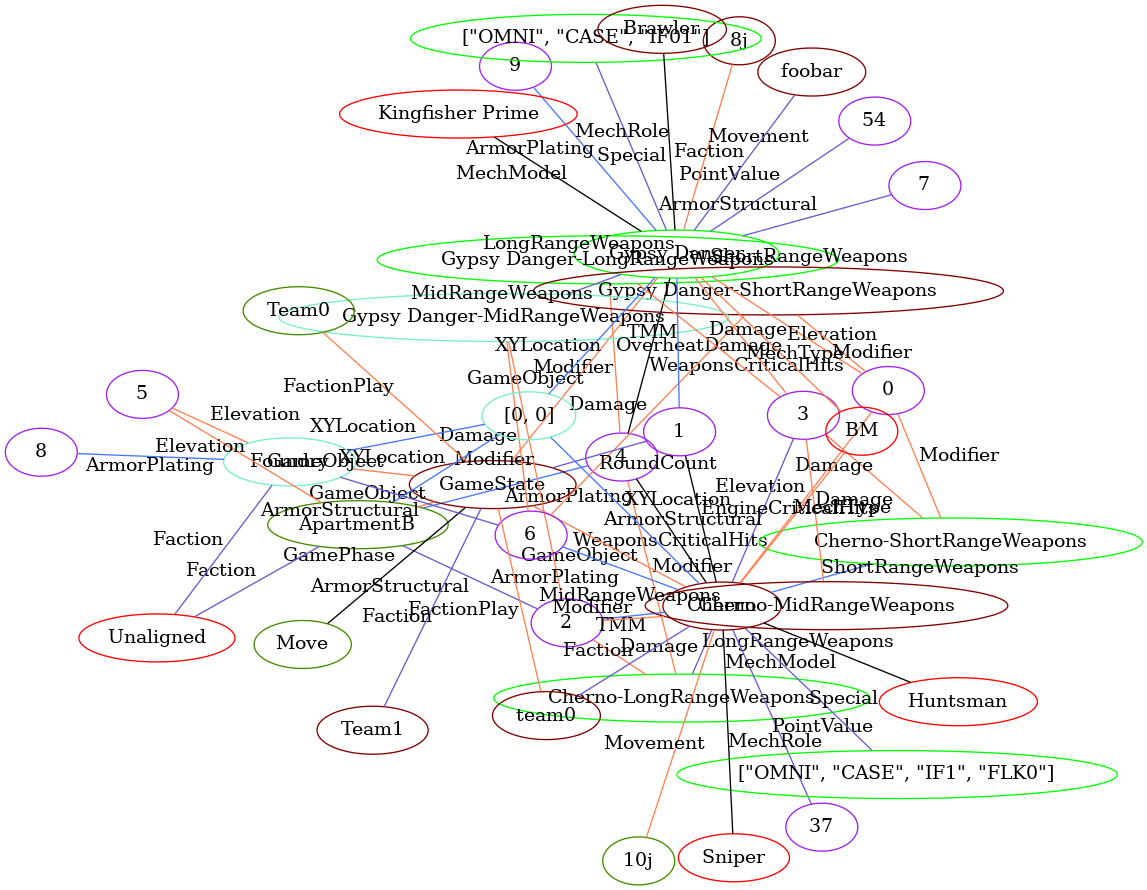

In [24]:
if __name__ == "__main__":
    # Player presses "start" button
    GameState.setFaction("foobar")
    # Player adds 2 objects
    MechFactories['Kingfisher Prime']("Gypsy Danger", "foobar")
    GameObject.build_system(GameState.__name__, "Gypsy Danger")

    StructureFactories['Apartment Tower']("ApartmentB")
    GameObject.build_system(GameState.__name__, "ApartmentB")

    # Player ends turn and control passes to other team
    GameState.setFaction("team0")
    MechFactories['Huntsman']("Cherno", "team0")
    GameObject.build_system(GameState.__name__, "Cherno")

    StructureFactories['Foundry']("Foundry")
    GameObject.build_system(GameState.__name__, "Foundry")

    # Player 2 ends turn; move to move phase from Add
    GameState.newPhase("Add")

    display(qs.render())

In [25]:
if __name__ == "__main__":
    print(f'{XYLocation.get_relationship("Gypsy Danger")} & {Elevation.get_relationship("Gypsy Danger")}')

[0, 0] & 0


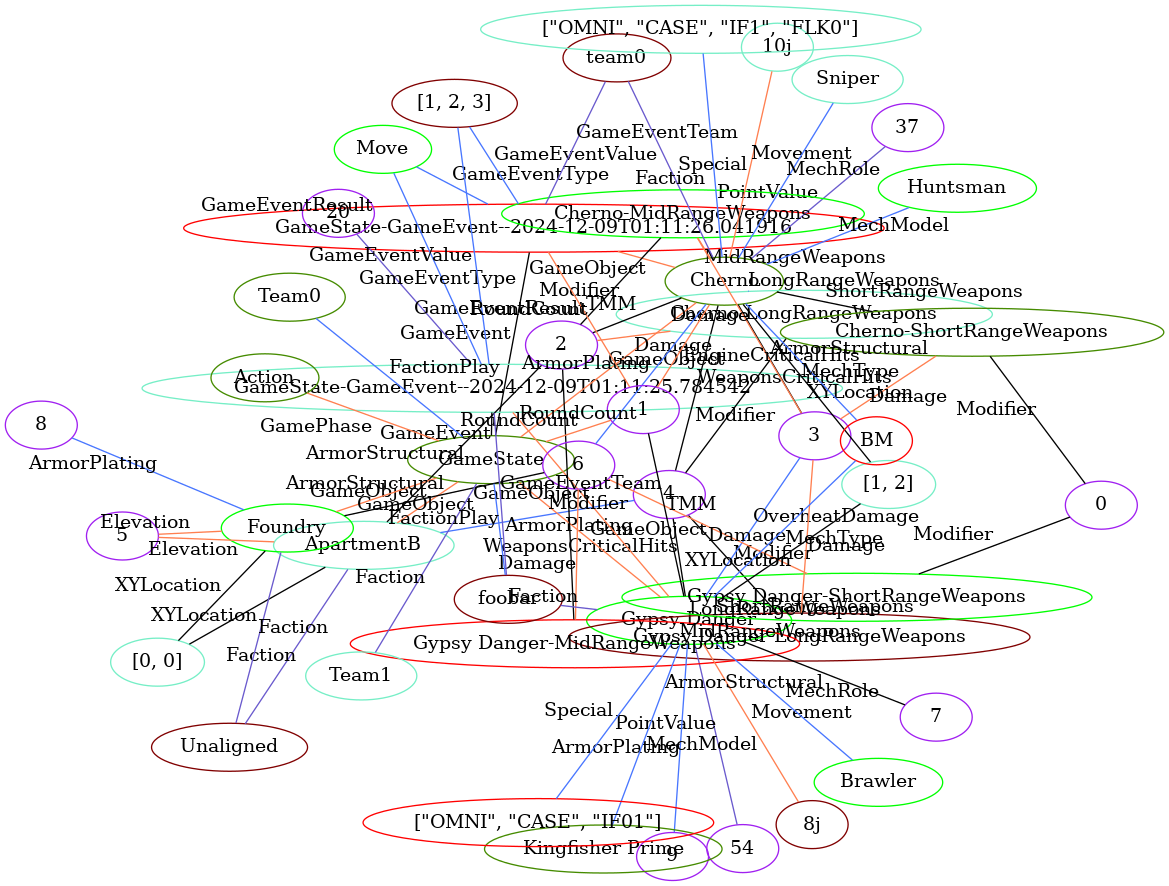

In [26]:
if __name__ == "__main__":
    GameState.setFaction("foobar")
    GameState.declareEvent((str(GameState.getRoundCount()), "Move", "foobar", "Gypsy Danger", "[1, 2, 3]", "20"))
    # All units from Foobar move or pass
    GameState.setFaction("team0")
    GameState.declareEvent((str(GameState.getRoundCount()),"Move", "team0", "Cherno", "[1, 2, 3]", "20"))
    # All units from Team0 move or pass
    GameState.setFaction("foobar")
    GameState.newPhase("Move")

    display(qs.render())

In [27]:
if __name__ == "__main__":
    print(f'{XYLocation.get_relationship("Gypsy Danger")} & {Elevation.get_relationship("Gypsy Danger")}')

[1, 2] & 3


In [28]:
if __name__ == "__main__":
    GameState.declareEvent((str(GameState.getRoundCount()),"Attack", "foobar", "Gypsy Danger", "Cherno", "20"))
    # All units from Team 0 take action or pass
    GameState.setFaction("team0")
    GameState.declareEvent((str(GameState.getRoundCount()),"Attack", "Team1", "Cherno", "Gypsy Danger", "20"))
    GameState.newPhase("Action")

    display(qs.render())

Exception: Unrecognized Event Type: Attack